## Persistent

In [1]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import re
from collections import defaultdict
import pprint
import math
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool

import psutil


In [2]:
import psutil
from typing import List

def count_idle_cpus(threshold: float = 10.0) -> int:
    """
    Count CPU cores with usage below the threshold.

    Args:
        threshold (float): Utilization percentage below which a core is considered idle.

    Returns:
        int: Number of idle CPU cores.
    """
    usage: List[float] = psutil.cpu_percent(percpu=True)
    return sum(1 for u in usage if u < threshold)


In [3]:
CPU_CORES = 16

In [4]:

class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

In [5]:
class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
    """

    def __init__(self, slope: Union[QQ, str], point: Point):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
        """
        self.slope = slope
        self.point = point

    @classmethod
    def from_points(cls, p1: Point, p2: Point) -> 'Line':
        """
        Construct a line from two points.

        The slope is computed from the two points. The stored point is p1 without any minimization.

        Args:
            p1 (Point): First point.
            p2 (Point): Second point.

        Returns:
            Line: Line through p1 and p2 with p1 stored as the point.
        """
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str]) -> 'Line':
        """
        Construct a line from a point and a slope.

        Args:
            p (Point): A point on the line.
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.

        Returns:
            Line: Line defined by the point and slope.
        """
        return cls(slope, p)


In [6]:

def slope_of_line(p1: Point, p2: Point) -> Union[QQ, str]:
    """
    Calculate the slope of the line segment connecting two points.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Union[QQ, str]: The slope as a rational number (QQ) if defined, otherwise the string 'inf' if the line is vertical.
    """
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0:
        return 'inf'
    return QQ(dy) / QQ(dx)

In [7]:
def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Determine if three points are pure_random.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).
        p3 (Point): The third point as a named tuple with integer coordinates (x, y).

    Returns:
        bool: True if the three points are pure_random, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

In [8]:
def plot_no_three_in_line(points: Iterable[Point], n: Optional[int] = None, title: str = "No-3-in-line Set") -> None:
    """
    Plot a set of points on an n x n grid, illustrating a no-3-in-line configuration.

    Args:
        points (Iterable[Point]): Iterable of points to plot.
        n (Optional[int]): Size of the grid. If None, computed from the points.
        title (str): Title of the plot.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    if n is None:
        n = max(max(xs), max(ys)) + 1

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.show()

In [9]:
def find_missing_data(data: Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]) -> Dict[str, Iterable[Tuple[int, Union[int, str]]]]:
    """
    Identify entries with missing data labeled as 'NO DATA' in intervals.

    Args:
        data (Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]): Dictionary mapping keys to iterables of (start, end) intervals.

    Returns:
        Dict[str, Iterable[Tuple[int, Union[int, str]]]]: Dictionary mapping keys to iterables of tuples containing the index of the interval and the start value where 'NO DATA' occurs.
    """
    missing = {}
    for key, intervals in data.items():
        missing_entries = []
        for i, (start, end) in enumerate(intervals):
            if end == 'NO DATA':
                missing_entries.append((i, start))
        if missing_entries:
            missing[key] = missing_entries
    return missing

In [10]:
def points_on_line_pp(p1: Point, p2: Point, grid_size: int) -> Set[Point]:
    """
    Generate points with integer coordinates on the line segment between two points,
    assuming the segment lies on a line with rational slope and intercept.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Set[Point]: Set of points on the line segment from p1 to p2.
    """
    s = slope_of_line(p1, p2)
    if s == 'inf':
        x = p1.x
        return {Point(x, y) for y in range(grid_size) if 0 <= x < grid_size}
    a = s
    b = QQ(p1.y) - a * QQ(p1.x)
    return {Point(x, int(y)) for x in range(grid_size)
            if (y := a * QQ(x) + b).denominator() == 1 and 0 <= y < grid_size}



In [17]:
def greedy(n: int, priority: Callable[[Point], float]) -> List[Point]:
    """
    Select points greedily from an n x n grid based on a priority function,
    ensuring no three selected points are pure_random

    Args:
        n (int): The dimension of the grid (points range from 0 to n-1 in both x and y).
        priority (Callable[[Point], float]): A function assigning a priority score to each point.

    Returns:
        List[Point]: Sorted list of selected points.
    """
    grid: List[Point] = [Point(x, y) for x in range(n) for y in range(n)]
    shuffle(grid)

    priorities = {p: priority(p) for p in grid}
    candidates: Set[Point] = set(grid)
    selected: Set[Point] = set()

    while candidates:
        print(f"Selected {len(selected)} points, {len(candidates)} candidates remaining")
        p = max(candidates, key=lambda pt: priorities[pt])

        candidates -= {
            q
            for s in selected 
            for q in points_on_line_pp(p, s, n)
        }
        selected.add(p)
    return sorted(selected)

## Priorities

In [18]:
lb = 30
ub = 200
step = 1

no_primes = 50

In [19]:
# NOISE = random.uniform(-0.1, 0.1) 
NOISE =  0

In [20]:
def pure_random_priority(n):
    def priority(point):
        return 0
    return priority


In [21]:
priority_functions = {
    'pure_random' : pure_random_priority,
}
@parallel(ncpus=CPU_CORES)
def run_greedy_for_strategy(n, strategy_name):
    priority_func = priority_functions[strategy_name](n)
    result = greedy(n, priority_func)
    print(f"Done greedy for n={n} with strategy {strategy_name}, len(result)={len(result)}")
    return (n, len(result), result)


In [22]:
inputs = [(n, 'pure_random') for n in range(lb, ub+1, step)]

results_pure_random = run_greedy_for_strategy(inputs)


results_pure_random = [res for (_, res) in results_pure_random]

results_pure_random_raw = [res[2] for res in results_pure_random]

results_pure_random = [res[:2] for res in results_pure_random]



Selected 0 points, 900 candidates remaining
Selected 1 points, 900 candidates remaining
Selected 1 points, 870 candidates remaining
Selected 2 points, 841 candidates remaining
Selected 3 points, 822 candidates remaining
Selected 4 points, 781 candidates remaining
Selected 5 points, 751 candidates remaining
Selected 6 points, 693 candidates remaining
Selected 7 points, 691 candidates remaining
Selected 8 points, 679 candidates remaining
Selected 9 points, 641 candidates remaining
Selected 10 points, 610 candidates remaining
Selected 11 points, 560 candidates remaining
Selected 12 points, 505 candidates remaining
Selected 13 points, 482 candidates remaining
Selected 14 points, 449 candidates remaining
Selected 15 points, 431 candidates remaining
Selected 16 points, 409 candidates remaining
Selected 17 points, 397 candidates remaining
Selected 18 points, 386 candidates remaining
Selected 19 points, 369 candidates remaining
Selected 20 points, 350 candidates remaining
Selected 21 points, 3

In [40]:
results = {
    'pure_random_count': results_pure_random,
}

In [41]:
print(results)

{'pure_random_count': [(30, 44), (31, 45), (32, 47), (33, 48), (34, 48), (35, 52), (36, 52), (37, 55), (38, 57), (40, 58), (41, 58), (39, 57), (44, 63), (45, 65), (48, 70), (42, 59), (43, 63), (51, 73), (46, 68), (47, 71), (53, 79), (49, 70), (50, 71), (54, 81), (55, 82), (56, 79), (52, 74), (58, 84), (57, 85), (59, 84), (60, 89), (62, 87), (64, 95), (61, 91), (66, 96), (65, 94), (69, 102), (68, 98), (63, 95), (71, 104), (70, 106), (67, 98), (73, 104), (72, 105), (74, 107), (76, 111), (75, 107), (77, 115), (79, 115), (78, 114), (81, 120), (84, 121), (82, 120), (85, 123), (87, 129), (80, 114), (83, 120), (86, 123), (88, 131), (90, 131), (89, 130), (93, 134), (92, 134), (91, 130), (94, 138), (95, 139), (96, 136), (97, 138), (99, 144), (98, 144), (104, 151), (105, 152), (103, 146), (106, 156), (100, 144), (107, 149), (101, 149), (102, 151), (109, 157), (110, 160), (111, 159), (113, 160), (114, 162), (108, 156), (112, 162), (115, 168), (116, 166), (118, 166), (117, 167), (120, 172), (123, 

## Analysis

In [2]:
results = {'pure_random_count': [(30, 44), (31, 45), (32, 47), (33, 48), (34, 48), (35, 52), (36, 52), (37, 55), (38, 57), (40, 58), (41, 58), (39, 57), (44, 63), (45, 65), (48, 70), (42, 59), (43, 63), (51, 73), (46, 68), (47, 71), (53, 79), (49, 70), (50, 71), (54, 81), (55, 82), (56, 79), (52, 74), (58, 84), (57, 85), (59, 84), (60, 89), (62, 87), (64, 95), (61, 91), (66, 96), (65, 94), (69, 102), (68, 98), (63, 95), (71, 104), (70, 106), (67, 98), (73, 104), (72, 105), (74, 107), (76, 111), (75, 107), (77, 115), (79, 115), (78, 114), (81, 120), (84, 121), (82, 120), (85, 123), (87, 129), (80, 114), (83, 120), (86, 123), (88, 131), (90, 131), (89, 130), (93, 134), (92, 134), (91, 130), (94, 138), (95, 139), (96, 136), (97, 138), (99, 144), (98, 144), (104, 151), (105, 152), (103, 146), (106, 156), (100, 144), (107, 149), (101, 149), (102, 151), (109, 157), (110, 160), (111, 159), (113, 160), (114, 162), (108, 156), (112, 162), (115, 168), (116, 166), (118, 166), (117, 167), (120, 172), (123, 181), (124, 182), (125, 180), (119, 168), (126, 184), (128, 186), (121, 178), (122, 179), (129, 188), (130, 189), (131, 190), (132, 191), (134, 196), (127, 189), (133, 190), (135, 194), (136, 198), (137, 199), (139, 198), (140, 205), (142, 203), (143, 209), (138, 200), (144, 212), (145, 211), (147, 215), (141, 204), (150, 215), (149, 212), (153, 216), (152, 221), (151, 220), (146, 214), (154, 221), (148, 211), (155, 223), (156, 222), (157, 229), (159, 228), (161, 238), (162, 236), (163, 235), (164, 237), (165, 244), (166, 237), (158, 230), (160, 232), (168, 240), (170, 244), (171, 245), (172, 248), (167, 239), (173, 248), (174, 249), (169, 239), (175, 248), (176, 248), (177, 247), (178, 256), (179, 257), (180, 256), (183, 257), (184, 264), (185, 266), (182, 261), (187, 262), (190, 265), (181, 258), (188, 269), (191, 270), (192, 273), (193, 276), (186, 275), (194, 275), (189, 275), (195, 276), (196, 276), (197, 282), (198, 278), (199, 279), (200, 286)]}


In [3]:
import matplotlib.pyplot as plt

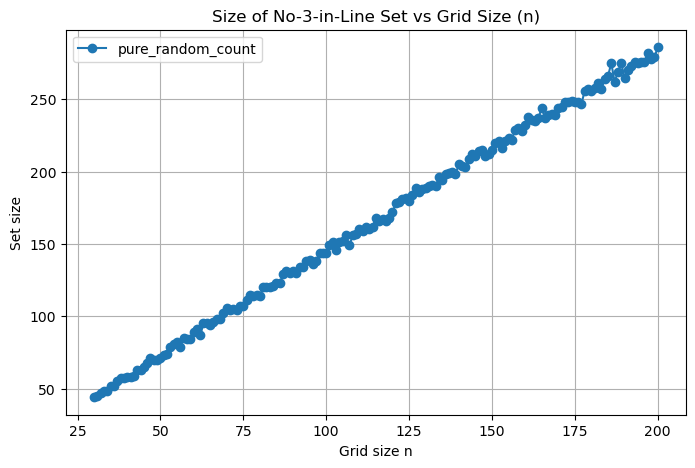

In [4]:
for strategy in results:
    results[strategy].sort(key=lambda x: x[0])

plt.figure(figsize=(8, 5))
for strategy, result_list in results.items():
    if result_list:
        ns, sizes = zip(*result_list)
        plt.plot(ns, sizes, marker='o', label=strategy, linestyle='-')

plt.title("Size of No-3-in-Line Set vs Grid Size (n)")
plt.xlabel("Grid size n")
plt.ylabel("Set size")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
for method, points in results.items():
    x_vals = [p[0] for p in points]
    y_vals = [p[1] for p in points]
    data = list(zip(x_vals, y_vals))
    
    var('a b t')
    model(t) = a * t + b
    fit = find_fit(data, model, solution_dict=True)
    slope = fit[a]
    print(f"{method}: slope ≈ {slope:.4f}")

print(results)

pure_random_count: slope ≈ 1.4188
{'pure_random_count': [(30, 44), (31, 45), (32, 47), (33, 48), (34, 48), (35, 52), (36, 52), (37, 55), (38, 57), (39, 57), (40, 58), (41, 58), (42, 59), (43, 63), (44, 63), (45, 65), (46, 68), (47, 71), (48, 70), (49, 70), (50, 71), (51, 73), (52, 74), (53, 79), (54, 81), (55, 82), (56, 79), (57, 85), (58, 84), (59, 84), (60, 89), (61, 91), (62, 87), (63, 95), (64, 95), (65, 94), (66, 96), (67, 98), (68, 98), (69, 102), (70, 106), (71, 104), (72, 105), (73, 104), (74, 107), (75, 107), (76, 111), (77, 115), (78, 114), (79, 115), (80, 114), (81, 120), (82, 120), (83, 120), (84, 121), (85, 123), (86, 123), (87, 129), (88, 131), (89, 130), (90, 131), (91, 130), (92, 134), (93, 134), (94, 138), (95, 139), (96, 136), (97, 138), (98, 144), (99, 144), (100, 144), (101, 149), (102, 151), (103, 146), (104, 151), (105, 152), (106, 156), (107, 149), (108, 156), (109, 157), (110, 160), (111, 159), (112, 162), (113, 160), (114, 162), (115, 168), (116, 166), (117, 16

In [6]:
data = results['pure_random_count']

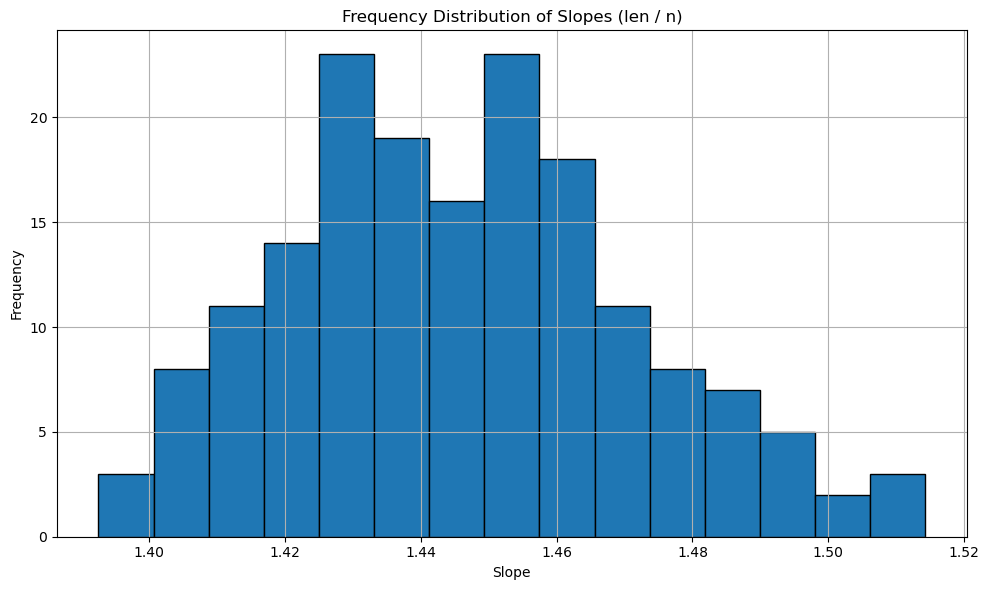

In [7]:
slopes = [length / n * 1.0 for n, length in data]

# Plot frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(slopes, bins=15, edgecolor='black')
plt.title('Frequency Distribution of Slopes (len / n)')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

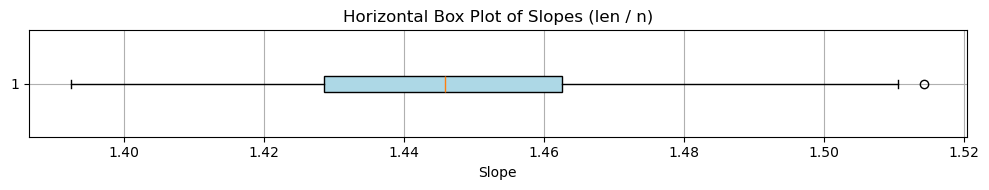

In [8]:
# Generate horizontal box plot of the slopes
plt.figure(figsize=(10, 2))
plt.boxplot(slopes, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Horizontal Box Plot of Slopes (len / n)')
plt.xlabel('Slope')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
mean_slope = sum(slopes) / len(slopes)
mean_slope

1.44627718644377